In [1]:
import xgboost as xgb
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from numpy import concatenate
from math import sqrt
import random
import matplotlib.pyplot as plt

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/dask/dataframe/utils.py:14: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
df = pd.read_csv('/Users/alexellard/Downloads/scenarios_data.csv', header=0, index_col=0)
df

,reservoir_demand,node_1_demand,node_2_demand,node_3_demand,node_4_demand,node_5_demand,node_6_demand,node_7_demand,node_8_demand,node_9_demand,...,link_23_flow,link_24_flow,link_25_flow,link_26_flow,link_27_flow,link_28_flow,link_29_flow,link_30_flow,link_31_flow,link_32_flow
Timestamp,,,,,,,,,,,,,,,,,,,,,
2017-01-01 00:00:00,-3348.0,154.8,169.2,18.0,118.8,169.2,234.0,86.4,82.8,104.4,...,439.2,-205.2,-75.6,-18.0,118.8,68.4,7.2,-54.0,75.6,212.4
2017-01-01 00:30:00,-2959.2,136.8,147.6,18.0,108.0,144.0,237.6,79.2,75.6,90.0,...,392.4,-187.2,-72.0,-21.6,108.0,61.2,3.6,-54.0,72.0,183.6
2017-01-01 01:00:00,-2692.8,129.6,126.0,14.4,104.4,133.2,205.2,72.0,72.0,90.0,...,349.2,-176.4,-64.8,-18.0,93.6,50.4,3.6,-39.6,54.0,151.2
2017-01-01 01:30:00,-2379.6,104.4,100.8,10.8,86.4,122.4,180.0,68.4,57.6,82.8,...,316.8,-158.4,-54.0,-10.8,79.2,46.8,7.2,-32.4,50.4,140.4
2017-01-01 02:00:00,-2228.4,104.4,104.4,10.8,79.2,122.4,183.6,68.4,54.0,75.6,...,277.2,-144.0,-57.6,-18.0,72.0,39.6,7.2,-32.4,43.2,118.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-31 21:30:00,-5306.4,205.2,208.8,39.6,183.6,284.4,316.8,176.4,133.2,129.6,...,604.8,-259.2,32.4,115.2,169.2,100.8,10.8,-100.8,122.4,309.6
2017-12-31 22:00:00,-4910.4,208.8,183.6,39.6,154.8,252.0,295.2,165.6,133.2,133.2,...,565.2,-241.2,21.6,100.8,154.8,86.4,18.0,-75.6,100.8,288.0
2017-12-31 22:30:00,-4683.6,187.2,183.6,36.0,147.6,230.4,320.4,147.6,118.8,126.0,...,529.2,-226.8,21.6,100.8,147.6,86.4,14.4,-86.4,108.0,266.4


In [3]:
# convert series to supervised learning
def series_to_supervised(data, n_in, n_out, vars_to_predict=None):
    n_vars = data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i-1))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(n_out):
        cols.append(df[vars_to_predict].shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in vars_to_predict]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in vars_to_predict]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    return agg

values = df.values
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))

# node 1 indexes
target_variable_demand_node1 = [1]
target_variable_pressures_node1 = [33]
target_variable_flows_node1 = [64]
#node 16 indexes
target_variable_demand_node16 = [16]
target_variable_pressures_node16 = [48]
target_variable_flows_node16 = [79]
#node 29 indexes
target_variable_demand_node29 = [29]
target_variable_pressures_node29 = [61]
target_variable_flows_node29 = [92]


reframed_demand_node1 = series_to_supervised(values, 1, 1, vars_to_predict=target_variable_demand_node1)
reframed_pressures_node1 = series_to_supervised(values, 1, 1, vars_to_predict=target_variable_pressures_node1)
reframed_flows_node1 = series_to_supervised(values, 1, 1, vars_to_predict=target_variable_flows_node1)

reframed_demand_node16 = series_to_supervised(values, 1, 1, vars_to_predict=target_variable_demand_node16)
reframed_pressures_node16 = series_to_supervised(values, 1, 1, vars_to_predict=target_variable_pressures_node16)
reframed_flows_node16 = series_to_supervised(values, 1, 1, vars_to_predict=target_variable_flows_node16)

reframed_demand_node29 = series_to_supervised(values, 1, 1, vars_to_predict=target_variable_demand_node29)
reframed_pressures_node29 = series_to_supervised(values, 1, 1, vars_to_predict=target_variable_pressures_node29)
reframed_flows_node29 = series_to_supervised(values, 1, 1, vars_to_predict=target_variable_flows_node29)

reframed_demand_node1 = reframed_demand_node1.drop(reframed_demand_node1.columns[1], axis=1)
reframed_pressures_node1 = reframed_pressures_node1.drop(reframed_pressures_node1.columns[33], axis=1)
reframed_flows_node1 = reframed_flows_node1.drop(reframed_flows_node1.columns[64], axis=1)

reframed_demand_node16 = reframed_demand_node16.drop(reframed_demand_node16.columns[16], axis=1)
reframed_pressures_node16 = reframed_pressures_node16.drop(reframed_pressures_node16.columns[48], axis=1)
reframed_flows_node16 = reframed_flows_node16.drop(reframed_flows_node16.columns[79], axis=1)

reframed_demand_node29 = reframed_demand_node29.drop(reframed_demand_node29.columns[29], axis=1)
reframed_pressures_node29 = reframed_pressures_node29.drop(reframed_pressures_node29.columns[61], axis=1)
reframed_flows_node29 = reframed_flows_node29.drop(reframed_flows_node29.columns[92], axis=1)

In [4]:
demands = [reframed_demand_node1, reframed_demand_node16, reframed_demand_node29]
pressures = [reframed_pressures_node1, reframed_pressures_node16, reframed_pressures_node29]
flows = [reframed_flows_node1, reframed_flows_node16, reframed_flows_node29]

parameters = [demands, pressures, flows]

In [5]:
MAE_scaled = []
RMSE_scaled = []
R2_scaled = []
MAE = []
RMSE = []
R2 = []
sensors_covered = []

for run in range(1,11):
    for parameter in parameters:
        for node in parameter:
            #select random columns to drop
            columns_to_drop = random.sample(list(node.columns), 8)
            # Drop the selected columns from the dataframe
            if node.columns[-1] in columns_to_drop:
                columns_to_drop.remove(node.columns[-1])
            node.drop(columns_to_drop, axis=1, inplace=True)
            print('Node shape: ', node.shape)

            # split into train and test sets
            values = node.values
            scaled = scaler.fit_transform(values)
            train, test = train_test_split(scaled, test_size=0.2, random_state=0)

            # split into input and outputs
            train_X, train_y = train[:, :-1], train[:, -1]
            test_X, test_y = test[:, :-1], test[:, -1]

            #define model
            model = xgb.XGBRegressor(
                objective='reg:squarederror',
                n_estimators=100,
                max_depth=6,
                learning_rate=0.1,
                subsample=0.9,
                colsample_bytree=0.8,
                random_state=42
            )

            # fit the model on the training data
            model.fit(train_X, train_y)

            # make predictions on the test data
            y_pred = model.predict(test_X)

            # calculate the mean squared error
            mae = mean_absolute_error(test_y, y_pred)
            MAE_scaled.append(mae)
            print(f'Run {run} Scaled Mean Absolute Error:', mae)
            rmse = sqrt(mean_squared_error(test_y, y_pred))
            RMSE_scaled.append(rmse)
            print(f'Run {run} Scaled RMSE: %.3f' % rmse)
            r2 = r2_score(test_y, y_pred)
            print(f'Run {run} Scaled R^2: %.3f' % r2)
            R2_scaled.append(r2)

            percentage_list = round(node.shape[1] / 96 * 100)
            sensors_covered.append(percentage_list)
            
            test_y = test_y.reshape((len(test_y), 1))
            inv_test_y = concatenate((test_y, test_X[:, -node.shape[1]:]), axis=1)
            test_y_inverse = scaler.inverse_transform(inv_test_y)
            test_y_inverse = test_y_inverse[:,0]

            y_pred = y_pred.reshape((len(y_pred), 1))
            inv_y_pred = concatenate((y_pred, test_X[:, -node.shape[1]:]), axis=1)
            y_pred_inverse = scaler.inverse_transform(inv_y_pred)
            y_pred_inverse = y_pred_inverse[:,0]

            # evaluate scaled errors
            mae_inverse = mean_absolute_error(test_y_inverse, y_pred_inverse)
            MAE.append(mae_inverse)
            print('Mean Absolute Error:', mae_inverse)
            rmse_inverse = sqrt(mean_squared_error(test_y_inverse, y_pred_inverse))
            RMSE.append(rmse_inverse)
            print('RMSE: %.3f' % rmse_inverse)
            r2_inverse = r2_score(test_y_inverse, y_pred_inverse)
            R2.append(r2_inverse)
            print('R^2: %.3f' % r2_inverse)


    #         # make a prediction
    #         yhat = model.predict(test_X)
    #         test_X = test_X.reshape((test_X.shape[0], test_X.shape[1]))
    #         # invert scaling for forecast
    #         print(yhat.shape)
    #         yhat_reshaped = yhat.reshape(-1, 1)
    #         scaler.min_ = scaler.min_.reshape(-1, 1)
    #         inv_yhat = concatenate((yhat_reshaped, test_X[:, 1:]), axis=1)
    #         print(yhat_reshaped.shape)
    #         print(test_X[:, 1:].shape)
    #         print(scaler.min_.shape)
    #         inv_yhat = scaler.inverse_transform(inv_yhat)
    #         inv_yhat = inv_yhat[:,0]
    #         # invert scaling for actual
    #         test_y = test_y.reshape((len(test_y), 1))
    #         inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
    #         inv_y = scaler.inverse_transform(inv_y)
    #         inv_y = inv_y[:,0]
    #         # calculate RMSE
    #          # calculate the mean squared error
    #         mae = mean_absolute_error(inv_y, inv_yhat)
    #         print(f'Mean Absolute Error Run {run}:', mae)
    #         rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
    #         print(f'Test RMSE: %.3f Run {run}' % rmse)

Node shape:  (87600, 88)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 1 Scaled Mean Absolute Error: 0.019428851
Run 1 Scaled RMSE: 0.025
Run 1 Scaled R^2: 0.976
Mean Absolute Error: 165.76695
RMSE: 215.600
R^2: 0.976
Node shape:  (87600, 88)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 1 Scaled Mean Absolute Error: 0.0055835196
Run 1 Scaled RMSE: 0.007
Run 1 Scaled R^2: 0.998
Mean Absolute Error: 47.63859
RMSE: 62.825
R^2: 0.998
Node shape:  (87600, 88)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 1 Scaled Mean Absolute Error: 0.00819792
Run 1 Scaled RMSE: 0.011
Run 1 Scaled R^2: 0.996
Mean Absolute Error: 69.94465
RMSE: 92.129
R^2: 0.996
Node shape:  (87600, 88)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 1 Scaled Mean Absolute Error: 0.001281069
Run 1 Scaled RMSE: 0.002
Run 1 Scaled R^2: 1.000
Mean Absolute Error: 10.930081
RMSE: 19.015
R^2: 1.000
Node shape:  (87600, 88)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 1 Scaled Mean Absolute Error: 0.00092467654
Run 1 Scaled RMSE: 0.001
Run 1 Scaled R^2: 1.000
Mean Absolute Error: 7.889341
RMSE: 10.881
R^2: 1.000
Node shape:  (87600, 88)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 1 Scaled Mean Absolute Error: 0.00032427863
Run 1 Scaled RMSE: 0.000
Run 1 Scaled R^2: 1.000
Mean Absolute Error: 2.766747
RMSE: 3.967
R^2: 1.000
Node shape:  (87600, 88)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 1 Scaled Mean Absolute Error: 0.00026821528
Run 1 Scaled RMSE: 0.000
Run 1 Scaled R^2: 1.000
Mean Absolute Error: 2.2884114
RMSE: 3.120
R^2: 1.000
Node shape:  (87600, 88)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 1 Scaled Mean Absolute Error: 0.003218476
Run 1 Scaled RMSE: 0.004
Run 1 Scaled R^2: 1.000
Mean Absolute Error: 27.460037
RMSE: 35.320
R^2: 1.000
Node shape:  (87600, 88)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 1 Scaled Mean Absolute Error: 0.0093323905
Run 1 Scaled RMSE: 0.012
Run 1 Scaled R^2: 0.995
Mean Absolute Error: 79.623955
RMSE: 102.366
R^2: 0.995
Node shape:  (87600, 80)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 2 Scaled Mean Absolute Error: 0.019237205
Run 2 Scaled RMSE: 0.025
Run 2 Scaled R^2: 0.977
Mean Absolute Error: 164.13182
RMSE: 213.563
R^2: 0.977
Node shape:  (87600, 80)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 2 Scaled Mean Absolute Error: 0.005675804
Run 2 Scaled RMSE: 0.008
Run 2 Scaled R^2: 0.998
Mean Absolute Error: 48.425957
RMSE: 64.184
R^2: 0.998
Node shape:  (87600, 80)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 2 Scaled Mean Absolute Error: 0.008420319
Run 2 Scaled RMSE: 0.011
Run 2 Scaled R^2: 0.995
Mean Absolute Error: 71.84216
RMSE: 94.390
R^2: 0.995
Node shape:  (87600, 80)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 2 Scaled Mean Absolute Error: 0.0013052797
Run 2 Scaled RMSE: 0.002
Run 2 Scaled R^2: 1.000
Mean Absolute Error: 11.136648
RMSE: 16.821
R^2: 1.000
Node shape:  (87600, 80)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 2 Scaled Mean Absolute Error: 0.0009246064
Run 2 Scaled RMSE: 0.001
Run 2 Scaled R^2: 1.000
Mean Absolute Error: 7.8887424
RMSE: 10.980
R^2: 1.000
Node shape:  (87600, 80)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 2 Scaled Mean Absolute Error: 0.00031175587
Run 2 Scaled RMSE: 0.000
Run 2 Scaled R^2: 1.000
Mean Absolute Error: 2.6599007
RMSE: 3.912
R^2: 1.000
Node shape:  (87600, 81)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 2 Scaled Mean Absolute Error: 0.00075762137
Run 2 Scaled RMSE: 0.001
Run 2 Scaled R^2: 1.000
Mean Absolute Error: 6.464025
RMSE: 8.539
R^2: 1.000
Node shape:  (87600, 80)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 2 Scaled Mean Absolute Error: 0.0031801164
Run 2 Scaled RMSE: 0.004
Run 2 Scaled R^2: 1.000
Mean Absolute Error: 27.132753
RMSE: 35.035
R^2: 1.000
Node shape:  (87600, 80)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 2 Scaled Mean Absolute Error: 0.010656081
Run 2 Scaled RMSE: 0.014
Run 2 Scaled R^2: 0.994
Mean Absolute Error: 90.91769
RMSE: 116.581
R^2: 0.994
Node shape:  (87600, 72)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 3 Scaled Mean Absolute Error: 0.019292787
Run 3 Scaled RMSE: 0.025
Run 3 Scaled R^2: 0.977
Mean Absolute Error: 164.60605
RMSE: 213.796
R^2: 0.977
Node shape:  (87600, 72)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 3 Scaled Mean Absolute Error: 0.005758387
Run 3 Scaled RMSE: 0.008
Run 3 Scaled R^2: 0.998
Mean Absolute Error: 49.130558
RMSE: 65.265
R^2: 0.998
Node shape:  (87600, 72)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 3 Scaled Mean Absolute Error: 0.008206621
Run 3 Scaled RMSE: 0.011
Run 3 Scaled R^2: 0.996
Mean Absolute Error: 4.2838564
RMSE: 5.660
R^2: 0.996
Node shape:  (87600, 72)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 3 Scaled Mean Absolute Error: 0.0012666147
Run 3 Scaled RMSE: 0.002
Run 3 Scaled R^2: 1.000
Mean Absolute Error: 10.806758
RMSE: 21.101
R^2: 1.000
Node shape:  (87600, 72)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 3 Scaled Mean Absolute Error: 0.0009819701
Run 3 Scaled RMSE: 0.001
Run 3 Scaled R^2: 1.000
Mean Absolute Error: 8.37817
RMSE: 11.597
R^2: 1.000
Node shape:  (87600, 72)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 3 Scaled Mean Absolute Error: 0.00034861895
Run 3 Scaled RMSE: 0.001
Run 3 Scaled R^2: 1.000
Mean Absolute Error: 2.9744167
RMSE: 4.324
R^2: 1.000
Node shape:  (87600, 73)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 3 Scaled Mean Absolute Error: 0.00035383189
Run 3 Scaled RMSE: 0.000
Run 3 Scaled R^2: 1.000
Mean Absolute Error: 3.0188942
RMSE: 3.985
R^2: 1.000
Node shape:  (87600, 72)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 3 Scaled Mean Absolute Error: 0.0032263622
Run 3 Scaled RMSE: 0.004
Run 3 Scaled R^2: 0.999
Mean Absolute Error: 27.527323
RMSE: 35.449
R^2: 0.999
Node shape:  (87600, 73)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 3 Scaled Mean Absolute Error: 0.010797383
Run 3 Scaled RMSE: 0.014
Run 3 Scaled R^2: 0.994
Mean Absolute Error: 92.123276
RMSE: 118.438
R^2: 0.994
Node shape:  (87600, 65)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 4 Scaled Mean Absolute Error: 0.019358847
Run 4 Scaled RMSE: 0.025
Run 4 Scaled R^2: 0.976
Mean Absolute Error: 8.990249
RMSE: 11.673
R^2: 0.976
Node shape:  (87600, 64)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 4 Scaled Mean Absolute Error: 0.005694986
Run 4 Scaled RMSE: 0.008
Run 4 Scaled R^2: 0.998
Mean Absolute Error: 2.9727829
RMSE: 3.934
R^2: 0.998
Node shape:  (87600, 64)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 4 Scaled Mean Absolute Error: 0.008131501
Run 4 Scaled RMSE: 0.011
Run 4 Scaled R^2: 0.996
Mean Absolute Error: 4.2446446
RMSE: 5.578
R^2: 0.996
Node shape:  (87600, 65)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 4 Scaled Mean Absolute Error: 0.001260634
Run 4 Scaled RMSE: 0.002
Run 4 Scaled R^2: 1.000
Mean Absolute Error: 10.755727
RMSE: 17.827
R^2: 1.000
Node shape:  (87600, 64)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 4 Scaled Mean Absolute Error: 0.0008909345
Run 4 Scaled RMSE: 0.001
Run 4 Scaled R^2: 1.000
Mean Absolute Error: 0.4650679
RMSE: 0.637
R^2: 1.000
Node shape:  (87600, 64)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 4 Scaled Mean Absolute Error: 0.0005415248
Run 4 Scaled RMSE: 0.001
Run 4 Scaled R^2: 1.000
Mean Absolute Error: 4.620289
RMSE: 6.442
R^2: 1.000
Node shape:  (87600, 65)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 4 Scaled Mean Absolute Error: 0.00040610819
Run 4 Scaled RMSE: 0.001
Run 4 Scaled R^2: 1.000
Mean Absolute Error: 3.4649193
RMSE: 4.543
R^2: 1.000
Node shape:  (87600, 65)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 4 Scaled Mean Absolute Error: 0.0033139258
Run 4 Scaled RMSE: 0.004
Run 4 Scaled R^2: 0.999
Mean Absolute Error: 28.274416
RMSE: 36.310
R^2: 0.999
Node shape:  (87600, 65)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 4 Scaled Mean Absolute Error: 0.010814569
Run 4 Scaled RMSE: 0.014
Run 4 Scaled R^2: 0.993
Mean Absolute Error: 92.269905
RMSE: 118.813
R^2: 0.993
Node shape:  (87600, 57)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 5 Scaled Mean Absolute Error: 0.019245122
Run 5 Scaled RMSE: 0.025
Run 5 Scaled R^2: 0.977
Mean Absolute Error: 9.560977
RMSE: 12.426
R^2: 0.977
Node shape:  (87600, 56)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 5 Scaled Mean Absolute Error: 0.009033751
Run 5 Scaled RMSE: 0.012
Run 5 Scaled R^2: 0.996
Mean Absolute Error: 4.7156186
RMSE: 6.069
R^2: 0.996
Node shape:  (87600, 56)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 5 Scaled Mean Absolute Error: 0.008583627
Run 5 Scaled RMSE: 0.011
Run 5 Scaled R^2: 0.995
Mean Absolute Error: 4.4806533
RMSE: 5.838
R^2: 0.995
Node shape:  (87600, 58)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 5 Scaled Mean Absolute Error: 0.0012660675
Run 5 Scaled RMSE: 0.002
Run 5 Scaled R^2: 1.000
Mean Absolute Error: 10.802089
RMSE: 16.542
R^2: 1.000
Node shape:  (87600, 56)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 5 Scaled Mean Absolute Error: 0.00088693056
Run 5 Scaled RMSE: 0.001
Run 5 Scaled R^2: 1.000
Mean Absolute Error: 0.4629778
RMSE: 0.644
R^2: 1.000
Node shape:  (87600, 56)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 5 Scaled Mean Absolute Error: 0.00051418046
Run 5 Scaled RMSE: 0.001
Run 5 Scaled R^2: 1.000
Mean Absolute Error: 4.386986
RMSE: 5.999
R^2: 1.000
Node shape:  (87600, 57)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 5 Scaled Mean Absolute Error: 0.0003285383
Run 5 Scaled RMSE: 0.000
Run 5 Scaled R^2: 1.000
Mean Absolute Error: 2.8030941
RMSE: 3.693
R^2: 1.000
Node shape:  (87600, 58)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 5 Scaled Mean Absolute Error: 0.007044015
Run 5 Scaled RMSE: 0.009
Run 5 Scaled R^2: 0.998
Mean Absolute Error: 60.099537
RMSE: 78.286
R^2: 0.998
Node shape:  (87600, 57)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 5 Scaled Mean Absolute Error: 0.011018762
Run 5 Scaled RMSE: 0.014
Run 5 Scaled R^2: 0.993
Mean Absolute Error: 94.01208
RMSE: 121.388
R^2: 0.993
Node shape:  (87600, 49)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 6 Scaled Mean Absolute Error: 0.019228693
Run 6 Scaled RMSE: 0.025
Run 6 Scaled R^2: 0.977
Mean Absolute Error: 9.552815
RMSE: 12.403
R^2: 0.977
Node shape:  (87600, 48)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 6 Scaled Mean Absolute Error: 0.020157004
Run 6 Scaled RMSE: 0.026
Run 6 Scaled R^2: 0.978
Mean Absolute Error: 10.521957
RMSE: 13.688
R^2: 0.978
Node shape:  (87600, 48)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 6 Scaled Mean Absolute Error: 0.008257972
Run 6 Scaled RMSE: 0.011
Run 6 Scaled R^2: 0.996
Mean Absolute Error: 4.3106623
RMSE: 5.654
R^2: 0.996
Node shape:  (87600, 51)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 6 Scaled Mean Absolute Error: 0.0012679594
Run 6 Scaled RMSE: 0.002
Run 6 Scaled R^2: 1.000
Mean Absolute Error: 10.818229
RMSE: 19.905
R^2: 1.000
Node shape:  (87600, 48)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 6 Scaled Mean Absolute Error: 0.0008985726
Run 6 Scaled RMSE: 0.001
Run 6 Scaled R^2: 1.000
Mean Absolute Error: 0.46905497
RMSE: 0.654
R^2: 1.000
Node shape:  (87600, 48)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 6 Scaled Mean Absolute Error: 0.000741835
Run 6 Scaled RMSE: 0.001
Run 6 Scaled R^2: 1.000
Mean Absolute Error: 6.329335
RMSE: 8.433
R^2: 1.000
Node shape:  (87600, 50)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 6 Scaled Mean Absolute Error: 0.0013594242
Run 6 Scaled RMSE: 0.002
Run 6 Scaled R^2: 1.000
Mean Absolute Error: 0.6313167
RMSE: 0.823
R^2: 1.000
Node shape:  (87600, 50)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 6 Scaled Mean Absolute Error: 0.007424901
Run 6 Scaled RMSE: 0.010
Run 6 Scaled R^2: 0.997
Mean Absolute Error: 63.34925
RMSE: 82.587
R^2: 0.997
Node shape:  (87600, 49)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 6 Scaled Mean Absolute Error: 0.019475589
Run 6 Scaled RMSE: 0.026
Run 6 Scaled R^2: 0.978
Mean Absolute Error: 166.16573
RMSE: 217.898
R^2: 0.978
Node shape:  (87600, 41)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 7 Scaled Mean Absolute Error: 0.018920321
Run 7 Scaled RMSE: 0.025
Run 7 Scaled R^2: 0.977
Mean Absolute Error: 9.399615
RMSE: 12.230
R^2: 0.977
Node shape:  (87600, 41)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 7 Scaled Mean Absolute Error: 0.021416591
Run 7 Scaled RMSE: 0.028
Run 7 Scaled R^2: 0.975
Mean Absolute Error: 11.1794615
RMSE: 14.598
R^2: 0.975
Node shape:  (87600, 40)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 7 Scaled Mean Absolute Error: 0.0115359835
Run 7 Scaled RMSE: 0.015
Run 7 Scaled R^2: 0.992
Mean Absolute Error: 6.0217834
RMSE: 7.728
R^2: 0.992
Node shape:  (87600, 43)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 7 Scaled Mean Absolute Error: 0.0012683526
Run 7 Scaled RMSE: 0.002
Run 7 Scaled R^2: 1.000
Mean Absolute Error: 0.09588751
RMSE: 0.164
R^2: 1.000
Node shape:  (87600, 41)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 7 Scaled Mean Absolute Error: 0.00093683176
Run 7 Scaled RMSE: 0.001
Run 7 Scaled R^2: 1.000
Mean Absolute Error: 0.48902616
RMSE: 0.678
R^2: 1.000
Node shape:  (87600, 40)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 7 Scaled Mean Absolute Error: 0.0006951296
Run 7 Scaled RMSE: 0.001
Run 7 Scaled R^2: 1.000
Mean Absolute Error: 5.9308457
RMSE: 7.954
R^2: 1.000
Node shape:  (87600, 42)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 7 Scaled Mean Absolute Error: 0.003075493
Run 7 Scaled RMSE: 0.004
Run 7 Scaled R^2: 1.000
Mean Absolute Error: 1.1625365
RMSE: 1.514
R^2: 1.000
Node shape:  (87600, 42)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 7 Scaled Mean Absolute Error: 0.009347036
Run 7 Scaled RMSE: 0.012
Run 7 Scaled R^2: 0.996
Mean Absolute Error: 4.8791523
RMSE: 6.406
R^2: 0.996
Node shape:  (87600, 41)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 7 Scaled Mean Absolute Error: 0.020126948
Run 7 Scaled RMSE: 0.027
Run 7 Scaled R^2: 0.976
Mean Absolute Error: 171.72311
RMSE: 226.844
R^2: 0.976
Node shape:  (87600, 33)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 8 Scaled Mean Absolute Error: 0.01922669
Run 8 Scaled RMSE: 0.025
Run 8 Scaled R^2: 0.977
Mean Absolute Error: 9.551822
RMSE: 12.418
R^2: 0.977
Node shape:  (87600, 33)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 8 Scaled Mean Absolute Error: 0.021376986
Run 8 Scaled RMSE: 0.028
Run 8 Scaled R^2: 0.975
Mean Absolute Error: 1.6161001
RMSE: 2.112
R^2: 0.975
Node shape:  (87600, 32)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 8 Scaled Mean Absolute Error: 0.012741292
Run 8 Scaled RMSE: 0.016
Run 8 Scaled R^2: 0.990
Mean Absolute Error: 6.650955
RMSE: 8.527
R^2: 0.990
Node shape:  (87600, 35)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 8 Scaled Mean Absolute Error: 0.001390145
Run 8 Scaled RMSE: 0.002
Run 8 Scaled R^2: 1.000
Mean Absolute Error: 0.105095014
RMSE: 0.147
R^2: 1.000
Node shape:  (87600, 33)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 8 Scaled Mean Absolute Error: 0.00095263094
Run 8 Scaled RMSE: 0.001
Run 8 Scaled R^2: 1.000
Mean Absolute Error: 0.44240165
RMSE: 0.606
R^2: 1.000
Node shape:  (87600, 33)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 8 Scaled Mean Absolute Error: 0.00074012316
Run 8 Scaled RMSE: 0.001
Run 8 Scaled R^2: 1.000
Mean Absolute Error: 6.3147287
RMSE: 8.437
R^2: 1.000
Node shape:  (87600, 35)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 8 Scaled Mean Absolute Error: 0.003219549
Run 8 Scaled RMSE: 0.004
Run 8 Scaled R^2: 1.000
Mean Absolute Error: 1.2169898
RMSE: 1.587
R^2: 1.000
Node shape:  (87600, 34)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 8 Scaled Mean Absolute Error: 0.009442478
Run 8 Scaled RMSE: 0.012
Run 8 Scaled R^2: 0.996
Mean Absolute Error: 4.6910233
RMSE: 6.147
R^2: 0.996
Node shape:  (87600, 34)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 8 Scaled Mean Absolute Error: 0.02025086
Run 8 Scaled RMSE: 0.027
Run 8 Scaled R^2: 0.976
Mean Absolute Error: 172.78036
RMSE: 228.924
R^2: 0.976
Node shape:  (87600, 25)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 9 Scaled Mean Absolute Error: 0.019286852
Run 9 Scaled RMSE: 0.025
Run 9 Scaled R^2: 0.977
Mean Absolute Error: 9.581709
RMSE: 12.424
R^2: 0.977
Node shape:  (87600, 25)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 9 Scaled Mean Absolute Error: 0.02267559
Run 9 Scaled RMSE: 0.030
Run 9 Scaled R^2: 0.972
Mean Absolute Error: 1.7142745
RMSE: 2.234
R^2: 0.972
Node shape:  (87600, 24)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 9 Scaled Mean Absolute Error: 0.012855838
Run 9 Scaled RMSE: 0.017
Run 9 Scaled R^2: 0.990
Mean Absolute Error: 6.710748
RMSE: 8.622
R^2: 0.990
Node shape:  (87600, 28)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 9 Scaled Mean Absolute Error: 0.0012693314
Run 9 Scaled RMSE: 0.002
Run 9 Scaled R^2: 1.000
Mean Absolute Error: 0.09596147
RMSE: 0.133
R^2: 1.000
Node shape:  (87600, 26)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 9 Scaled Mean Absolute Error: 0.0012100389
Run 9 Scaled RMSE: 0.002
Run 9 Scaled R^2: 1.000
Mean Absolute Error: 0.5619419
RMSE: 0.787
R^2: 1.000
Node shape:  (87600, 25)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 9 Scaled Mean Absolute Error: 0.0007786425
Run 9 Scaled RMSE: 0.001
Run 9 Scaled R^2: 1.000
Mean Absolute Error: 6.643378
RMSE: 8.972
R^2: 1.000
Node shape:  (87600, 27)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 9 Scaled Mean Absolute Error: 0.0033201703
Run 9 Scaled RMSE: 0.004
Run 9 Scaled R^2: 1.000
Mean Absolute Error: 1.2550247
RMSE: 1.635
R^2: 1.000
Node shape:  (87600, 26)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 9 Scaled Mean Absolute Error: 0.010023162
Run 9 Scaled RMSE: 0.013
Run 9 Scaled R^2: 0.995
Mean Absolute Error: 4.979507
RMSE: 6.506
R^2: 0.995
Node shape:  (87600, 26)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 9 Scaled Mean Absolute Error: 0.021685617
Run 9 Scaled RMSE: 0.028
Run 9 Scaled R^2: 0.973
Mean Absolute Error: 185.0217
RMSE: 243.153
R^2: 0.973
Node shape:  (87600, 18)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 10 Scaled Mean Absolute Error: 0.021687843
Run 10 Scaled RMSE: 0.028
Run 10 Scaled R^2: 0.970
Mean Absolute Error: 10.774521
RMSE: 14.089
R^2: 0.970
Node shape:  (87600, 17)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 10 Scaled Mean Absolute Error: 0.023164092
Run 10 Scaled RMSE: 0.030
Run 10 Scaled R^2: 0.971
Mean Absolute Error: 1.751205
RMSE: 2.283
R^2: 0.971
Node shape:  (87600, 16)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 10 Scaled Mean Absolute Error: 0.02146989
Run 10 Scaled RMSE: 0.028
Run 10 Scaled R^2: 0.970
Mean Absolute Error: 11.207282
RMSE: 14.670
R^2: 0.970
Node shape:  (87600, 20)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 10 Scaled Mean Absolute Error: 0.0024630225
Run 10 Scaled RMSE: 0.004
Run 10 Scaled R^2: 0.999
Mean Absolute Error: 0.1862045
RMSE: 0.328
R^2: 0.999
Node shape:  (87600, 18)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 10 Scaled Mean Absolute Error: 0.0016248449
Run 10 Scaled RMSE: 0.002
Run 10 Scaled R^2: 1.000
Mean Absolute Error: 0.754578
RMSE: 1.052
R^2: 1.000
Node shape:  (87600, 17)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 10 Scaled Mean Absolute Error: 0.0009059074
Run 10 Scaled RMSE: 0.001
Run 10 Scaled R^2: 1.000
Mean Absolute Error: 7.7292023
RMSE: 10.541
R^2: 1.000
Node shape:  (87600, 19)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 10 Scaled Mean Absolute Error: 0.0038730325
Run 10 Scaled RMSE: 0.005
Run 10 Scaled R^2: 0.999
Mean Absolute Error: 1.4640063
RMSE: 1.914
R^2: 0.999
Node shape:  (87600, 18)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 10 Scaled Mean Absolute Error: 0.010727607
Run 10 Scaled RMSE: 0.014
Run 10 Scaled R^2: 0.994
Mean Absolute Error: 5.3294754
RMSE: 6.976
R^2: 0.994
Node shape:  (87600, 18)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 10 Scaled Mean Absolute Error: 0.022471366
Run 10 Scaled RMSE: 0.029
Run 10 Scaled R^2: 0.971
Mean Absolute Error: 5.824578
RMSE: 7.625
R^2: 0.971


In [6]:
demand_errors_mae_node1 = MAE[::9]
demand_errors_mae_node16 = MAE[1::9]
demand_errors_mae_node29 = MAE[2::9]
pressure_errors_mae_node1 = MAE[3::9]
pressure_errors_mae_node16 = MAE[4::9]
pressure_errors_mae_node29 = MAE[5::9]
flow_errors_mae_node1 = MAE[6::9]
flow_errors_mae_node16 = MAE[7::9]
flow_errors_mae_node29 = MAE[8::9]

demand_errors_rmse_node1 = RMSE[::9]
demand_errors_rmse_node16 = RMSE[1::9]
demand_errors_rmse_node29 = RMSE[2::9]
pressure_errors_rmse_node1 = RMSE[3::9]
pressure_errors_rmse_node16 = RMSE[4::9]
pressure_errors_rmse_node29 = RMSE[5::9]
flow_errors_rmse_node1 = RMSE[6::9]
flow_errors_rmse_node16 = RMSE[7::9]
flow_errors_rmse_node29 = RMSE[8::9]

demand_errors_r2_node1 = R2[::9]
demand_errors_r2_node16 = R2[1::9]
demand_errors_r2_node29 = R2[2::9]
pressure_errors_r2_node1 = R2[3::9]
pressure_errors_r2_node16 = R2[4::9]
pressure_errors_r2_node29 = R2[5::9]
flow_errors_r2_node1 = R2[6::9]
flow_errors_r2_node16 = R2[7::9]
flow_errors_r2_node29 = R2[8::9]

demand_sensors_covered_node1 = sensors_covered[::9]
demand_sensors_covered_node16 = sensors_covered[1::9]
demand_sensors_covered_node29 = sensors_covered[2::9]
pressure_sensors_covered_node1 = sensors_covered[3::9]
pressure_sensors_covered_node16 = sensors_covered[4::9]
pressure_sensors_covered_node29 = sensors_covered[5::9]
flow_sensors_covered_node1 = sensors_covered[6::9]
flow_sensors_covered_node16 = sensors_covered[7::9]
flow_sensors_covered_node29 = sensors_covered[8::9]

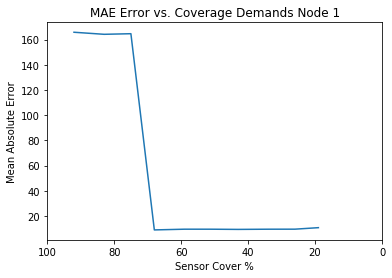

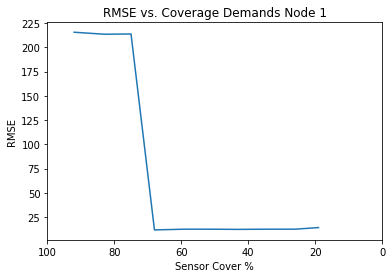

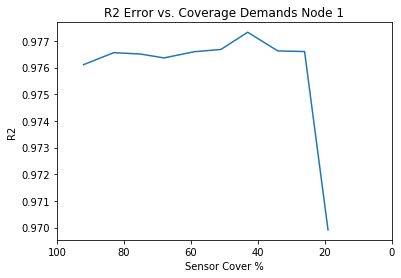

In [33]:
plt.plot(demand_sensors_covered_node1, demand_errors_mae_node1)
plt.ylabel("Mean Absolute Error")
plt.xlabel("Sensor Cover %")
plt.title("MAE Error vs. Coverage Demands Node 1")
plt.xlim([100, 0])
plt.show()

plt.plot(demand_sensors_covered_node1, demand_errors_rmse_node1)
plt.ylabel("RMSE")
plt.xlabel("Sensor Cover %")
plt.title("RMSE vs. Coverage Demands Node 1")
plt.xlim([100, 0])
plt.show()

plt.plot(demand_sensors_covered_node1, demand_errors_r2_node1)
plt.ylabel("R2")
plt.xlabel("Sensor Cover %")
plt.title("R2 Error vs. Coverage Demands Node 1")
plt.xlim([100, 0])
plt.show()

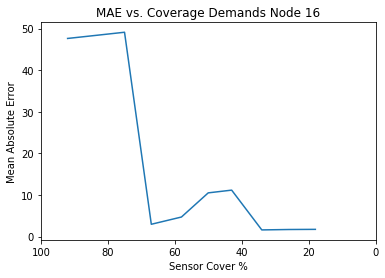

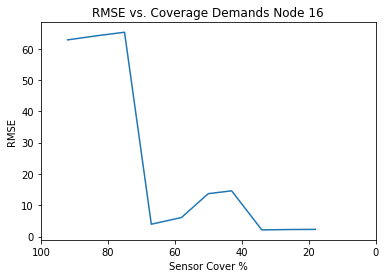

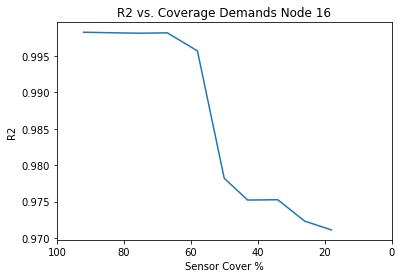

In [34]:
plt.plot(demand_sensors_covered_node16, demand_errors_mae_node16)
plt.ylabel("Mean Absolute Error")
plt.xlabel("Sensor Cover %")
plt.title("MAE vs. Coverage Demands Node 16")
plt.xlim([100, 0])
plt.savefig('/Users/alexellard/Downloads/DemandsMAEnode16.png')
plt.show()

plt.plot(demand_sensors_covered_node16, demand_errors_rmse_node16)
plt.ylabel("RMSE")
plt.xlabel("Sensor Cover %")
plt.title("RMSE vs. Coverage Demands Node 16")
plt.xlim([100, 0])
plt.show()

plt.plot(demand_sensors_covered_node16, demand_errors_r2_node16)
plt.ylabel("R2")
plt.xlabel("Sensor Cover %")
plt.title("R2 vs. Coverage Demands Node 16")
plt.xlim([100, 0])
plt.savefig('/Users/alexellard/Downloads/DemandsR2node16.png')
plt.show()

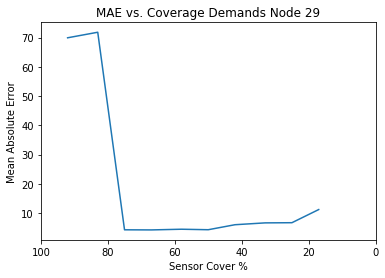

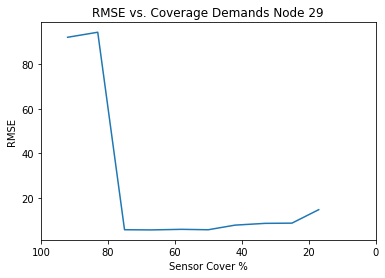

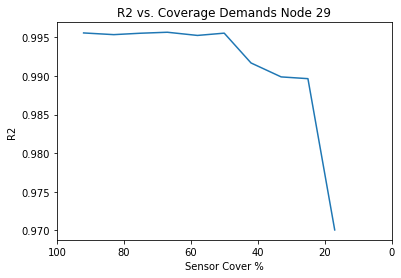

In [35]:
plt.plot(demand_sensors_covered_node29, demand_errors_mae_node29)
plt.ylabel("Mean Absolute Error")
plt.xlabel("Sensor Cover %")
plt.title("MAE vs. Coverage Demands Node 29")
plt.xlim([100, 0])
plt.show()

plt.plot(demand_sensors_covered_node29, demand_errors_rmse_node29)
plt.ylabel("RMSE")
plt.xlabel("Sensor Cover %")
plt.title("RMSE vs. Coverage Demands Node 29")
plt.xlim([100, 0])
plt.show()

plt.plot(demand_sensors_covered_node29, demand_errors_r2_node29)
plt.ylabel("R2")
plt.xlabel("Sensor Cover %")
plt.title("R2 vs. Coverage Demands Node 29")
plt.xlim([100, 0])
plt.show()

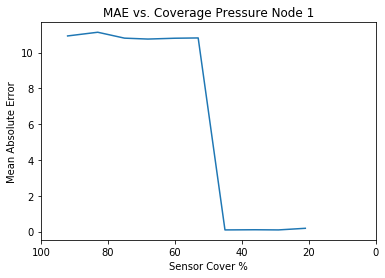

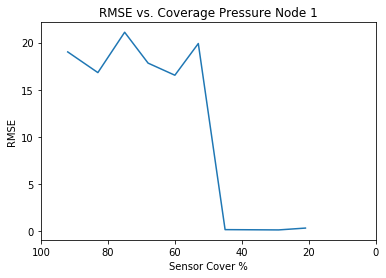

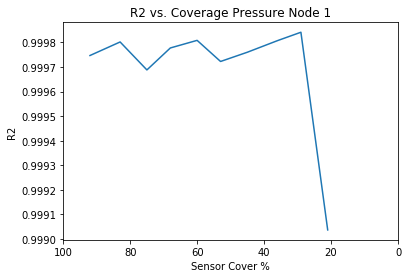

In [36]:
plt.plot(pressure_sensors_covered_node1, pressure_errors_mae_node1)
plt.ylabel("Mean Absolute Error")
plt.xlabel("Sensor Cover %")
plt.title("MAE vs. Coverage Pressure Node 1")
plt.xlim([100, 0])
plt.show()

plt.plot(pressure_sensors_covered_node1, pressure_errors_rmse_node1)
plt.ylabel("RMSE")
plt.xlabel("Sensor Cover %")
plt.title("RMSE vs. Coverage Pressure Node 1")
plt.xlim([100, 0])
plt.show()

plt.plot(pressure_sensors_covered_node1, pressure_errors_r2_node1)
plt.ylabel("R2")
plt.xlabel("Sensor Cover %")
plt.title("R2 vs. Coverage Pressure Node 1")
plt.xlim([100, 0])
plt.show()

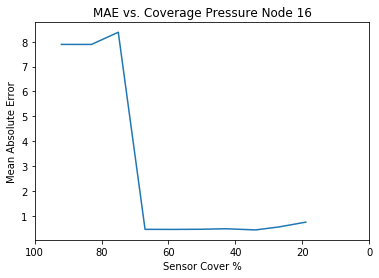

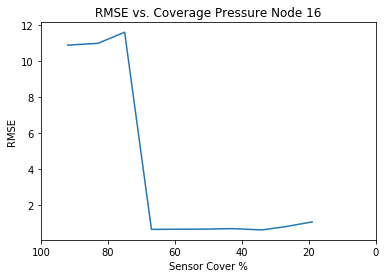

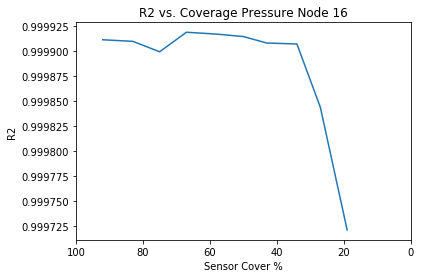

In [37]:
plt.plot(pressure_sensors_covered_node16, pressure_errors_mae_node16)
plt.ylabel("Mean Absolute Error")
plt.xlabel("Sensor Cover %")
plt.title("MAE vs. Coverage Pressure Node 16")
plt.xlim([100, 0])
plt.show()

plt.plot(pressure_sensors_covered_node16, pressure_errors_rmse_node16)
plt.ylabel("RMSE")
plt.xlabel("Sensor Cover %")
plt.title("RMSE vs. Coverage Pressure Node 16")
plt.xlim([100, 0])
plt.show()

plt.plot(pressure_sensors_covered_node16, pressure_errors_r2_node16)
plt.ylabel("R2")
plt.xlabel("Sensor Cover %")
plt.title("R2 vs. Coverage Pressure Node 16")
plt.xlim([100, 0])
plt.show()

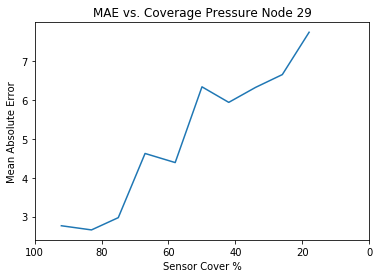

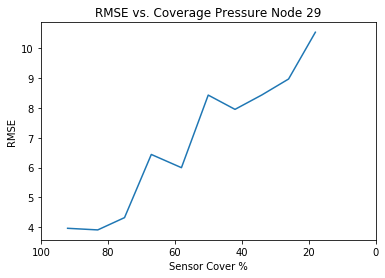

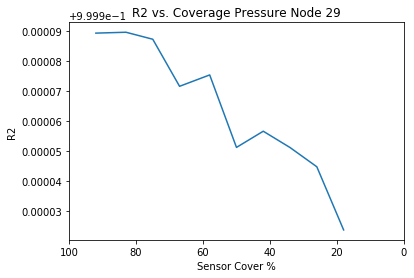

In [38]:
plt.plot(pressure_sensors_covered_node29, pressure_errors_mae_node29)
plt.ylabel("Mean Absolute Error")
plt.xlabel("Sensor Cover %")
plt.title("MAE vs. Coverage Pressure Node 29")
plt.xlim([100, 0])
plt.savefig('/Users/alexellard/Downloads/PressureMAEnode29.png')
plt.show()

plt.plot(pressure_sensors_covered_node29, pressure_errors_rmse_node29)
plt.ylabel("RMSE")
plt.xlabel("Sensor Cover %")
plt.title("RMSE vs. Coverage Pressure Node 29")
plt.xlim([100, 0])
plt.show()

plt.plot(pressure_sensors_covered_node29, pressure_errors_r2_node29)
plt.ylabel("R2")
plt.xlabel("Sensor Cover %")
plt.title("R2 vs. Coverage Pressure Node 29")
plt.xlim([100, 0])
plt.savefig('/Users/alexellard/Downloads/PressureR2node29.png')
plt.show()

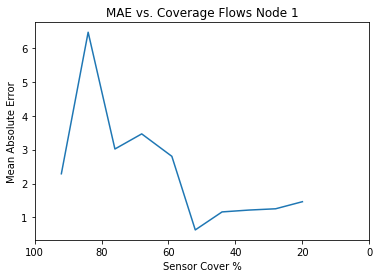

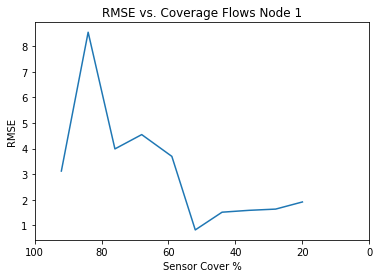

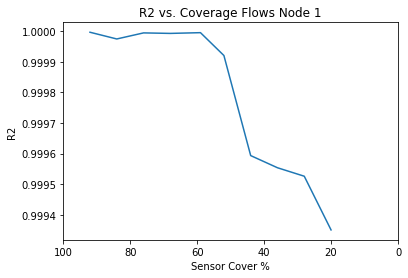

In [39]:
plt.plot(flow_sensors_covered_node1, flow_errors_mae_node1)
plt.ylabel("Mean Absolute Error")
plt.xlabel("Sensor Cover %")
plt.title("MAE vs. Coverage Flows Node 1")
plt.xlim([100, 0])
plt.savefig('/Users/alexellard/Downloads/flowsMAEnode1.png')
plt.show()

plt.plot(flow_sensors_covered_node1, flow_errors_rmse_node1)
plt.ylabel("RMSE")
plt.xlabel("Sensor Cover %")
plt.title("RMSE vs. Coverage Flows Node 1")
plt.xlim([100, 0])
plt.show()

plt.plot(flow_sensors_covered_node1, flow_errors_r2_node1)
plt.ylabel("R2")
plt.xlabel("Sensor Cover %")
plt.title("R2 vs. Coverage Flows Node 1")
plt.xlim([100, 0])
plt.savefig('/Users/alexellard/Downloads/flowsR2node1.png')
plt.show()

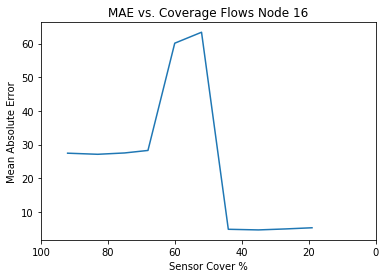

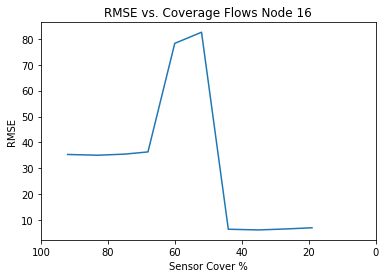

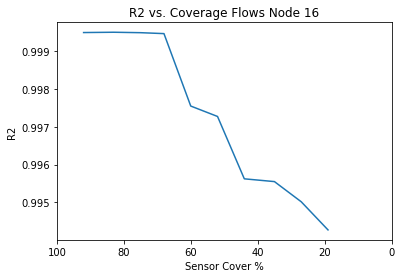

In [40]:
plt.plot(flow_sensors_covered_node16, flow_errors_mae_node16)
plt.ylabel("Mean Absolute Error")
plt.xlabel("Sensor Cover %")
plt.title("MAE vs. Coverage Flows Node 16")
plt.xlim([100, 0])
plt.show()

plt.plot(flow_sensors_covered_node16, flow_errors_rmse_node16)
plt.ylabel("RMSE")
plt.xlabel("Sensor Cover %")
plt.title("RMSE vs. Coverage Flows Node 16")
plt.xlim([100, 0])
plt.show()

plt.plot(flow_sensors_covered_node16, flow_errors_r2_node16)
plt.ylabel("R2")
plt.xlabel("Sensor Cover %")
plt.title("R2 vs. Coverage Flows Node 16")
plt.xlim([100, 0])
plt.show()

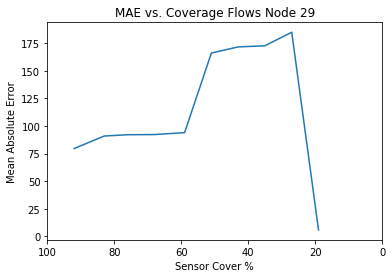

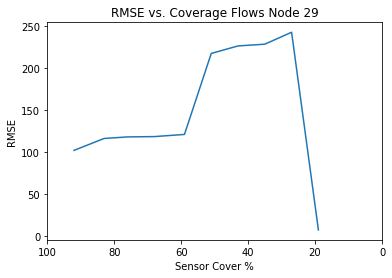

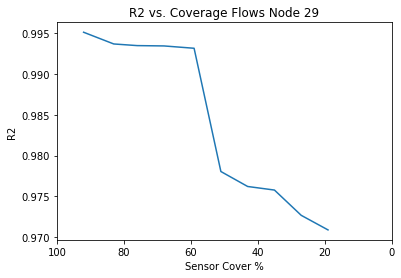

In [41]:
plt.plot(flow_sensors_covered_node29, flow_errors_mae_node29)
plt.ylabel("Mean Absolute Error")
plt.xlabel("Sensor Cover %")
plt.title("MAE vs. Coverage Flows Node 29")
plt.xlim([100, 0])
plt.show()

plt.plot(flow_sensors_covered_node29, flow_errors_rmse_node29)
plt.ylabel("RMSE")
plt.xlabel("Sensor Cover %")
plt.title("RMSE vs. Coverage Flows Node 29")
plt.xlim([100, 0])
plt.show()

plt.plot(flow_sensors_covered_node29, flow_errors_r2_node29)
plt.ylabel("R2")
plt.xlabel("Sensor Cover %")
plt.title("R2 vs. Coverage Flows Node 29")
plt.xlim([100, 0])
plt.show()